# Image Compression and Generation using Variational Autoencoders in Python

## Task 1: Introduction

Resources

- [Resource 1: Blog Post](https://www.jeremyjordan.me/variational-autoencoders/)
- [Resource 2: Theory Post](https://ermongroup.github.io/cs228-notes/inference/variational/)
- [Resource 3: Lecture Video](https://www.youtube.com/watch?v=P78QYjWh5sM&feature=youtu.be)

In addition, our VAE model in PyTorch has been adapted from the official PyTorch implementation you can find in [this repo](https://github.com/pytorch/examples/tree/master/vae). Enjoy the project!

In [1]:
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image

from tqdm.notebook import tqdm

import os
import shutil
import random
random.seed(5)

import matplotlib
%matplotlib inline
%config InlineBackend.figure_format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import numpy as np

In [2]:
epochs = 1000
batch_size = 64
torch.manual_seed(17)

## Task 2: Creating Data Loaders and Training/Validation Split.

### We use the MNIST handwritten digits dataset.

In [3]:
transforms_set = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    #transforms.Resize(size=50),
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('/files/', train=True, download=True,transform=transforms_set),
    batch_size=batch_size,shuffle=True
)

val_loader=torch.utils.data.DataLoader(
    datasets.MNIST('/files/', train=False, download=True,
                             transform=transforms_set),
    batch_size=batch_size,shuffle = True
)


  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



## Task 3: Exploratory data analysis 

In [4]:
examples = enumerate(val_loader)
batch_idx, (example_data, example_targets) = next(examples)

In [5]:
example_data.shape

torch.Size([64, 1, 28, 28])

([], <a list of 0 Text major ticklabel objects>)

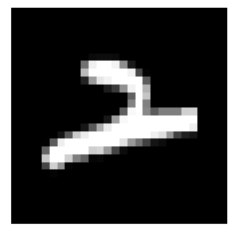

In [6]:

plt.imshow(example_data[0][0], cmap='gray')
plt.xticks([])
plt.yticks([])


## Task 4: VAE Architecture and Model Creation

In [7]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        
        # need to fill in dimensions here
    
        z = 32
        
        self.fc1 = nn.Linear(28*28,200)
        self.fc21 = nn.Linear(200,z) #mean
        self.fc22 = nn.Linear(200,z) #std
        self.fc3 = nn.Linear(z,200)
        self.fc4 = nn.Linear(200,28*28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        
        # don't forget forward pass re-index
        
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [8]:
def loss_function(recon_x, x, mu, logvar):
    
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 28*28), reduction='sum')

    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD

In [9]:
device= torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:',device)
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(),lr=1e-3)

Device: cuda


## Task 5: Training Loop

In [10]:
from os import mkdir; 
mkdir('Models')
mkdir('Results')

In [11]:
def evaluate(evaluate_data=val_loader):
    
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(evaluate_data):
            
            data = data.to(device) 
            recon_batch,mu,logvar= model(data)
            val_loss +=loss_function(recon_batch,data,mu,logvar).item()
            if i == 0:
                n = min(data.size(0), 16)
                comparison = torch.cat([data[:n],
                                        recon_batch.view(batch_size, 1, 28, 28)[:n]])
                save_image(comparison.cpu(),
                           'Results/reconstruction_' + str(epoch) + '.jpg', nrow=n)

    val_loss /= len(evaluate_data.dataset)
    return val_loss


def sample_latent_space(epoch):
    with torch.no_grad():
        
        # how to sample from our latent space
        sample = torch.randn(64,32).to(device)
        sample=model.decode(sample).cpu()
        save_image(sample.view(64, 1, 28, 28),
                   'Results/sample_' + str(epoch) + '.jpg')

In [12]:
def train(epoch):

    model.train()
    train_loss = 0
    
    progress_bar = tqdm(train_loader, desc='Epoch {:03d}'.format(epoch), leave=False, disable=False)
    for data, _ in progress_bar:
        
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch,mu,logvar=model(data)
        loss=loss_function(recon_batch,data,mu,logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item() / len(data))})

    average_train_loss = train_loss / len(train_loader.dataset)
    tqdm.write('Training set loss (average, epoch {:03d}): {:.3f}'.format(epoch, average_train_loss))
    val_loss = evaluate(val_loader)
    tqdm.write('\t\t\t\t====> Validation set loss: {:.3f}'.format(val_loss))

    train_losses.append(average_train_loss)
    val_losses.append(val_loss)
    
    if epoch%50==0:
        torch.save(model.state_dict(), f'Models/epoch_{epoch}.model')

In [13]:
epochs=45

In [14]:
train_losses,val_losses=[],[]
    
for epoch in range(1,epochs+1):
    train(epoch)
    sample_latent_space(epoch)
np.savetxt('Models/training_losses.txt', np.array(train_losses), delimiter='\n')
np.savetxt('Models/validation_losses.txt', np.array(val_losses), delimiter='\n')

Epoch 001:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 001): -20917.617
				====> Validation set loss: -29378.388


Epoch 002:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 002): -30573.350
				====> Validation set loss: -32776.592


Epoch 003:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 003): -33200.942
				====> Validation set loss: -34693.642


Epoch 004:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 004): -34869.431
				====> Validation set loss: -35918.992


Epoch 005:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 005): -35870.424
				====> Validation set loss: -36756.025


Epoch 006:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 006): -36514.924
				====> Validation set loss: -37224.541


Epoch 007:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 007): -36963.756
				====> Validation set loss: -37545.369


Epoch 008:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 008): -37239.934
				====> Validation set loss: -37867.793


Epoch 009:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 009): -37466.868
				====> Validation set loss: -37938.146


Epoch 010:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 010): -37645.363
				====> Validation set loss: -38104.150


Epoch 011:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 011): -37785.676
				====> Validation set loss: -38263.530


Epoch 012:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 012): -37927.357
				====> Validation set loss: -38320.653


Epoch 013:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 013): -38032.418
				====> Validation set loss: -38337.294


Epoch 014:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 014): -38130.240
				====> Validation set loss: -38516.287


Epoch 015:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 015): -38244.847
				====> Validation set loss: -38658.725


Epoch 016:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 016): -38336.023
				====> Validation set loss: -38595.428


Epoch 017:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 017): -38403.085
				====> Validation set loss: -38682.893


Epoch 018:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 018): -38480.740
				====> Validation set loss: -38731.809


Epoch 019:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 019): -38536.233
				====> Validation set loss: -38924.023


Epoch 020:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 020): -38583.680
				====> Validation set loss: -38915.074


Epoch 021:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 021): -38629.316
				====> Validation set loss: -38987.754


Epoch 022:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 022): -38663.743
				====> Validation set loss: -38919.237


Epoch 023:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 023): -38689.285
				====> Validation set loss: -38859.358


Epoch 024:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 024): -38716.942
				====> Validation set loss: -39075.020


Epoch 025:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 025): -38748.201
				====> Validation set loss: -39075.788


Epoch 026:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 026): -38769.212
				====> Validation set loss: -39088.380


Epoch 027:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 027): -38792.439
				====> Validation set loss: -39184.205


Epoch 028:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 028): -38815.380
				====> Validation set loss: -39223.035


Epoch 029:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 029): -38827.218
				====> Validation set loss: -39048.791


Epoch 030:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 030): -38852.159
				====> Validation set loss: -39131.005


Epoch 031:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 031): -38864.630
				====> Validation set loss: -39279.268


Epoch 032:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 032): -38884.004
				====> Validation set loss: -39181.025


Epoch 033:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 033): -38975.398
				====> Validation set loss: -39337.794


Epoch 034:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 034): -39003.732
				====> Validation set loss: -39391.265


Epoch 035:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 035): -39013.280
				====> Validation set loss: -39254.505


Epoch 036:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 036): -39025.737
				====> Validation set loss: -39136.073


Epoch 037:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 037): -39044.484
				====> Validation set loss: -39261.049


Epoch 038:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 038): -39044.182
				====> Validation set loss: -39226.657


Epoch 039:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 039): -39059.726
				====> Validation set loss: -39431.760


Epoch 040:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 040): -39066.598
				====> Validation set loss: -39436.172


Epoch 041:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 041): -39081.803
				====> Validation set loss: -39408.604


Epoch 042:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 042): -39087.754
				====> Validation set loss: -39428.234


Epoch 043:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 043): -39098.267
				====> Validation set loss: -39386.793


Epoch 044:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 044): -39110.524
				====> Validation set loss: -39184.367


Epoch 045:   0%|          | 0/938 [00:00<?, ?it/s]

Training set loss (average, epoch 045): -39107.694
				====> Validation set loss: -39394.096


## Task 6: Results and Other Uses

In [15]:
train_losses = np.loadtxt('Models/training_losses.txt')
val_losses=np.loadtxt('Models/validation_losses.txt')

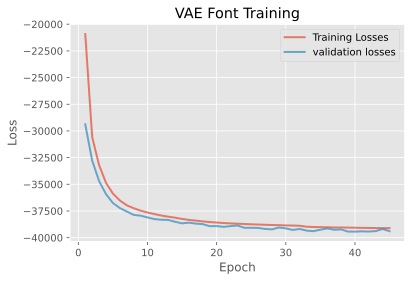

In [16]:
plt.plot(
    range(1,len(train_losses)+1),
    train_losses,
    label='Training Losses',
    linewidth=2,
    alpha=0.7
)
plt.plot(
    range(1,len(val_losses)+1),
    val_losses,
    label='validation losses',
    linewidth=2,
    alpha=0.7
)
plt.title('VAE Font Training')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
pass

## Digits Reconstruction After 30 epochs

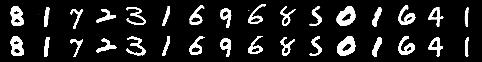

In [17]:
from IPython.display import Image, display
display(Image('/content/Results/reconstruction_30.jpg'))


## Digits Reconstruction After 45 epochs

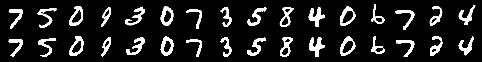

In [18]:
display(Image('/content/Results/reconstruction_45.jpg'))


### Digit Reconstruction (2-D Latent Space) at 30 epochs

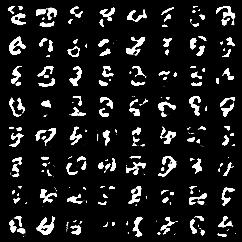

In [19]:
display(Image('/content/Results/sample_30.jpg'))

### Digit Reconstruction (2-D Latent Space) at 45 epochs

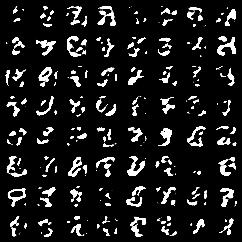

In [20]:
display(Image('/content/Results/sample_45.jpg'))